In [1]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as tf_hub  # Needed for Inception V1
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras import layers as Layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

print("Libraries loaded.")
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version




Libraries loaded.
GPU available: False


In [2]:

# ==========================================
# 2. CONFIGURATION
# ==========================================
class Config:
    # Inception V1 expects 224x224 images
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    CHANNELS = 3
    BATCH_SIZE = 32  # Reduced batch size for larger images
    LEARNING_RATE = 0.0001
    EPOCHS = 5
    NUM_CLASSES = 26


In [3]:

# ==========================================
# 3. LOAD DATA
# ==========================================
print("\n1. Loading Dataset...")
# Update path if necessary
try:
    data = pd.read_csv('A_Z Handwritten Data.csv').astype('float32')
except FileNotFoundError:
    # Fallback for different path structures
    data = pd.read_csv('e:/FCAI/Deep Learning/Sections/code/A_Z Handwritten Data.csv').astype('float32')

print(f"Original Shape: {data.shape}")

# Data Cleaning
data.drop_duplicates(inplace=True)
data.fillna(0, inplace=True)

X = data.drop('0', axis=1).values
y = data['0'].values

# Reshape to original 28x28 grayscale
X = X.reshape(-1, 28, 28, 1)

print(f"Shape after cleaning: {X.shape}")



# First split: 80% Train, 20% Temp (Test + Val)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: Split Temp into 50% Val and 50% Test (resulting in 10% Val, 10% Test total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)



# Free up RAM by deleting original dataframe
del data, X, y
gc.collect()



1. Loading Dataset...
Original Shape: (372450, 785)
Shape after cleaning: (201095, 28, 28, 1)


0

In [4]:
print("Data loaded and split successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data loaded and split successfully.
X_train shape: (120657, 28, 28, 1)
X_test shape: (40219, 28, 28, 1)
y_train shape: (120657,)
y_test shape: (40219,)



Class Distribution:
  A: 4608 samples
  B: 2882 samples
  C: 7302 samples
  D: 3258 samples
  E: 3623 samples
  F: 688 samples
  G: 1923 samples
  H: 2384 samples
  I: 637 samples
  J: 2756 samples
  K: 1894 samples
  L: 3736 samples
  M: 6224 samples
  N: 5945 samples
  O: 17584 samples
  P: 6052 samples
  Q: 1969 samples
  R: 3702 samples
  S: 14773 samples
  T: 7019 samples
  U: 8953 samples
  V: 1570 samples
  W: 3482 samples
  X: 2134 samples
  Y: 3500 samples
  Z: 2059 samples


C:\Users\DELL\AppData\Local\Temp\ipykernel_21636\4265630477.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_list, rotation=0)


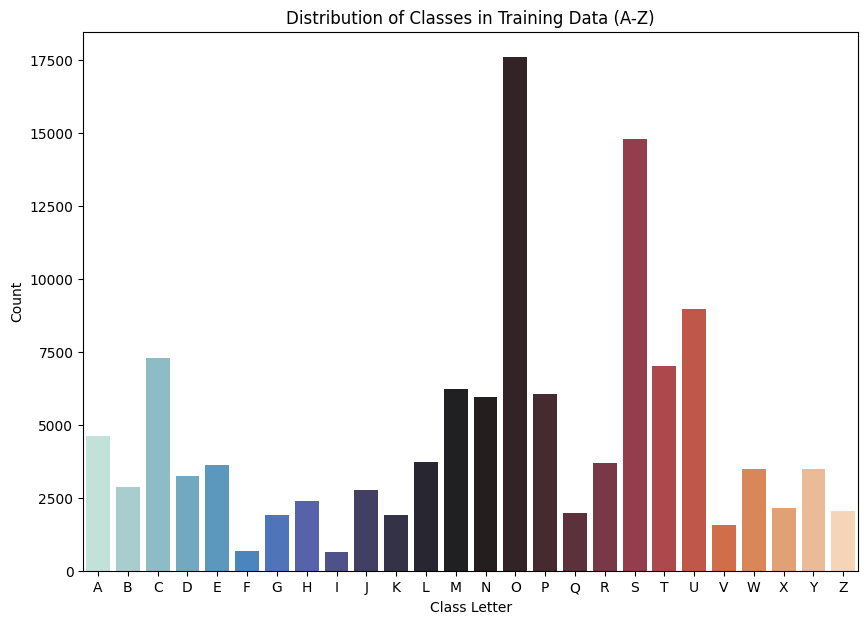

In [5]:
# Visualize number of classes with letter labels
plt.figure(figsize=(10,7))

# Create class mapping (Index -> Letter)
class_mapping = {i: chr(65+i) for i in range(26)}
labels_list = [chr(65+i) for i in range(26)]

# Create countplot with letter labels
ax = sns.countplot(x=y_train, hue=y_train, palette="icefire", legend=False)

ax.set_xticklabels(labels_list, rotation=0)

plt.title("Distribution of Classes in Training Data (A-Z)")
plt.xlabel("Class Letter")
plt.ylabel("Count")

# Show value counts using numpy with letter names only
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass Distribution:")
for label, count in zip(unique, counts):
    letter = class_mapping[int(label)]
    print(f"  {letter}: {count} samples")

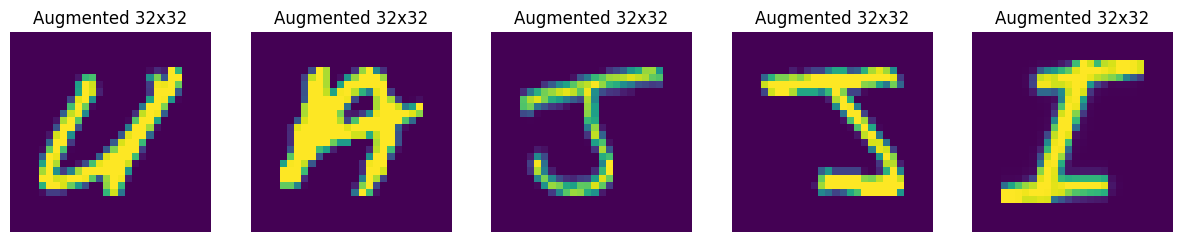

In [6]:
import matplotlib.pyplot as plt
import numpy as np

indices = [1, 10000, 40000,  50000, -4]

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)
    
    # Get the image
    img = X_train[idx]
    
    # To visualize correctly, we normalize it back to 0-1 range.
    img_display = (img - img.min()) / (img.max() - img.min())
    
    # No reshaping needed, it is already 32x32x3 which imshow accepts directly
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("Augmented 32x32")

plt.show()

In [7]:
# Define Augmentation Layers
data_augmentation = tf.keras.Sequential([
    # Random rotation (-10 to +10 degrees is usually safe for handwriting)
    Layers.RandomRotation(0.03), 
    # Random zoom to simulate different writing sizes
    Layers.RandomZoom(0.1),      
    # Random translation (shifting slightly)
    Layers.RandomTranslation(0.1, 0.1) 
])

def augment_image(image, label):
    """
    Applies random transformations to the image.
    """
    image = data_augmentation(image)
    return image, label

In [8]:
# ==========================================
# 4. TF.DATA PIPELINE (Memory Efficient)
# ==========================================
print("\n2. Building Data Pipeline (Resize 28x28 -> 224x224)...")
def process_image(image, label):
    """
    1. Resize image to 224x224 (Required by Inception V1)
    2. Convert 1 channel (grayscale) to 3 channels (RGB)
    3. Ensure float32 type
    4. Cast labels to integer and convert to one-hot
    5. EXPLICITLY SET SHAPES (Crucial fix)
    """
    # Resize
    image = tf.image.resize(image, [Config.IMG_HEIGHT, Config.IMG_WIDTH])
    # Convert grayscale to RGB by repeating channels
    image = tf.image.grayscale_to_rgb(image)
    # Ensure image dtype
    image = tf.cast(image, tf.float32)
    # Ensure label is integer type before one-hot
    label = tf.cast(label, tf.int32)
    # Label to one-hot
    label = tf.one_hot(label, Config.NUM_CLASSES)
    
    image.set_shape([Config.IMG_HEIGHT, Config.IMG_WIDTH, 3])

    label.set_shape([Config.NUM_CLASSES])
    
    return image, label

# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Optimize Pipelines
train_ds = (train_ds
            .shuffle(1000)
            .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) 
            .batch(Config.BATCH_SIZE, drop_remainder=True) 
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
           .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(Config.BATCH_SIZE, drop_remainder=True) 
           .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(Config.BATCH_SIZE, drop_remainder=True) 
           .prefetch(tf.data.AUTOTUNE))

print("Data Pipeline Ready.")



2. Building Data Pipeline (Resize 28x28 -> 224x224)...
Data Pipeline Ready.



Demonstrating Data Augmentation effectiveness...


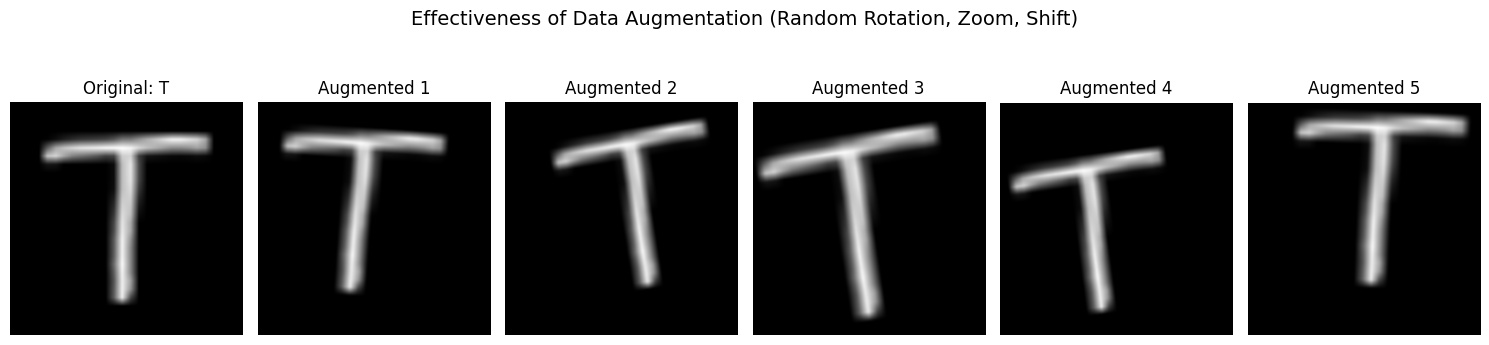

✓ Visual check: You should see the same letter rotated, shifted, or zoomed differently in the plots above.


In [ ]:
# ==========================================
# 4.1 DEMONSTRATION OF AUGMENTATION
# ==========================================
print("\nDemonstrating Data Augmentation effectiveness...")

# Grab a single sample image from the raw training set
demo_idx = 100 
sample_img = X_train[demo_idx]
sample_label = class_mapping[int(y_train[demo_idx])]


processed_img, _ = process_image(sample_img, 0) 

plt.figure(figsize=(15, 4))

# Plot Original (Processed)
plt.subplot(1, 6, 1)
plt.imshow(processed_img / 255.0) # Normalize for display
plt.title(f"Original: {sample_label}")
plt.axis("off")

# Plot 5 Random Augmentations of the SAME image
for i in range(5):
    # Apply augmentation to a single image (shape: H, W, C). Pass training=True
    # so random transforms are applied for visualization.
    augmented_img = data_augmentation(processed_img, training=True)

    plt.subplot(1, 6, i+2)
    plt.imshow(augmented_img / 255.0)
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.suptitle("Effectiveness of Data Augmentation (Random Rotation, Zoom, Shift)", fontsize=14)
plt.tight_layout()
plt.show()

print("✓ Visual check: You should see the same letter rotated, shifted, or zoomed differently in the plots above.")

In [9]:

# ==========================================
# 5. MODEL: INCEPTION V1 (GoogLeNet)
# ==========================================
print("="*70)
print("LOADING PRE-TRAINED INCEPTION V1 (GoogLeNet) FROM TENSORFLOW HUB")
print("="*70)

INCEPTION_V1_URL = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"
print(f"\n✓ Pre-trained Model URL: {INCEPTION_V1_URL}")
print(f"✓ Training Data: ImageNet (1.2M images, 1000 classes)")
print(f"✓ Architecture: Inception V1 (GoogLeNet)")
print(f"✓ Status: Using Transfer Learning")

# Load the SavedModel from TF Hub once
hub_saved_model = tf_hub.load(INCEPTION_V1_URL)

def build_pretrained_inception_v1(num_classes, lr=Config.LEARNING_RATE):
    """
    Transfer learning with PRE-TRAINED Inception V1 (TensorFlow Hub feature vector)
    """
    # Input tensor (float32, 0-255 range coming from dataset)
    inputs = tf.keras.Input(shape=(Config.IMG_HEIGHT, Config.IMG_WIDTH, 3), dtype=tf.float32, name="inputs")

    # Scale to [0,1] as required by the model
    x = Layers.Rescaling(1.0/255.0, name="rescale")(inputs)

    # Call TF Hub SavedModel via Lambda
    def hub_call_fn(t):
        return hub_saved_model(t)

    features = Layers.Lambda(hub_call_fn, name="inception_v1_feature_vector")(x)

    # Classification head
    x = Layers.Dense(256, activation="relu", name="fc1")(features)
    x = Layers.Dropout(0.3, name="drop1")(x)
    outputs = Layers.Dense(num_classes, activation="softmax", name="preds")(x)

    model = Model(inputs=inputs, outputs=outputs, name="inception_v1_transfer")
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy", # Changed to categorical because we use one-hot in pipeline
                  metrics=["accuracy"])
    return model

print("\n" + "="*70)
print("TRAINING PRE-TRAINED INCEPTION V1 WITH TRANSFER LEARNING")
print("="*70)

# Build Model
model = build_pretrained_inception_v1(Config.NUM_CLASSES)
model.summary()


LOADING PRE-TRAINED INCEPTION V1 (GoogLeNet) FROM TENSORFLOW HUB

✓ Pre-trained Model URL: https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5
✓ Training Data: ImageNet (1.2M images, 1000 classes)
✓ Architecture: Inception V1 (GoogLeNet)
✓ Status: Using Transfer Learning




TRAINING PRE-TRAINED INCEPTION V1 WITH TRANSFER LEARNING


Model: "inception_v1_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v1_feature_vector     │ (None, 1024)           │             0 │
│ (Lambda)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,082 (1.03 MB)

 Trainable params: 269,082 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# ==========================================
# 6. TRAINING
# ==========================================
print("\n" + "="*70)
print("STARTING TRAINING...")
print("="*70 + "\n")

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.EPOCHS,
    callbacks=[early_stop, reduce_lr]
)




STARTING TRAINING...

Epoch 1/5
3770/3770 ━━━━━━━━━━━━━━━━━━━━ 1232s 326ms/step - accuracy: 0.7313 - loss: 0.9998 - val_accuracy: 0.8861 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 2/5
3770/3770 ━━━━━━━━━━━━━━━━━━━━ 1161s 308ms/step - accuracy: 0.8707 - loss: 0.4553 - val_accuracy: 0.9171 - val_loss: 0.2993 - learning_rate: 1.0000e-04
Epoch 3/5
3770/3770 ━━━━━━━━━━━━━━━━━━━━ 1091s 289ms/step - accuracy: 0.8994 - loss: 0.3521 - val_accuracy: 0.9313 - val_loss: 0.2423 - learning_rate: 1.0000e-04
Epoch 4/5
3770/3770 ━━━━━━━━━━━━━━━━━━━━ 1090s 289ms/step - accuracy: 0.9133 - loss: 0.2989 - val_accuracy: 0.9392 - val_loss: 0.2145 - learning_rate: 1.0000e-04
Epoch 5/5
3770/3770 ━━━━━━━━━━━━━━━━━━━━ 1087s 288ms/step - accuracy: 0.9232 - loss: 0.2657 - val_accuracy: 0.9429 - val_loss: 0.1972 - learning_rate: 1.0000e-04


5. Evaluating...


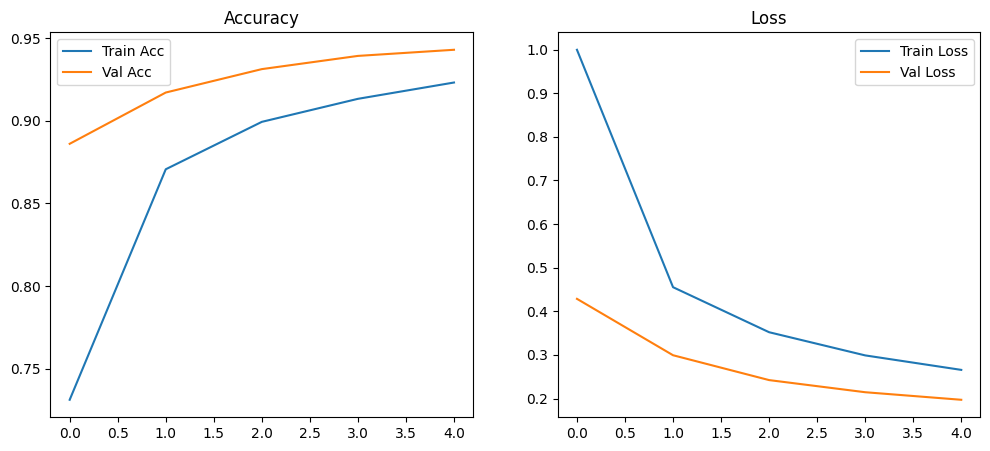

In [11]:
# ==========================================
# 7. EVALUATION
# ==========================================
print("5. Evaluating...")

# A. Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [12]:
# B. Predictions
# Get true labels from dataset 
y_true = []
y_pred_probs = []

# Iterate over test dataset to get predictions
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

labels_list = [chr(65+i) for i in range(26)]

In [13]:
# C. Metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=labels_list))



Classification Report:

              precision    recall  f1-score   support

           A       0.94      0.95      0.95      1536
           B       0.92      0.93      0.92       960
           C       0.96      0.93      0.95      2432
           D       0.93      0.83      0.88      1084
           E       0.89      0.91      0.90      1208
           F       0.96      0.85      0.90       227
           G       0.93      0.86      0.90       641
           H       0.97      0.91      0.94       794
           I       0.96      0.96      0.96       212
           J       0.95      0.87      0.91       917
           K       0.93      0.89      0.91       631
           L       0.95      0.93      0.94      1244
           M       0.96      0.97      0.97      2073
           N       0.93      0.90      0.91      1980
           O       0.96      0.98      0.97      5857
           P       0.97      0.95      0.96      2017
           Q       0.92      0.88      0.90       656
  


FINAL TEST SET EVALUATION

Computing final metrics...
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 248s 198ms/step - accuracy: 0.9428 - loss: 0.1980
Test Accuracy: 94.28%
Test Loss: 0.1980

Generating predictions for detailed analysis...

Final Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.95      0.95      1536
           B       0.92      0.93      0.92       960
           C       0.96      0.93      0.95      2432
           D       0.93      0.83      0.88      1084
           E       0.89      0.91      0.90      1208
           F       0.96      0.85      0.90       227
           G       0.93      0.86      0.90       641
           H       0.97      0.91      0.94       794
           I       0.96      0.96      0.96       212
           J       0.95      0.87      0.91       917
           K       0.93      0.89      0.91       631
           L       0.95      0.93      0.94      1244
           M       0.96      0.97      0.9

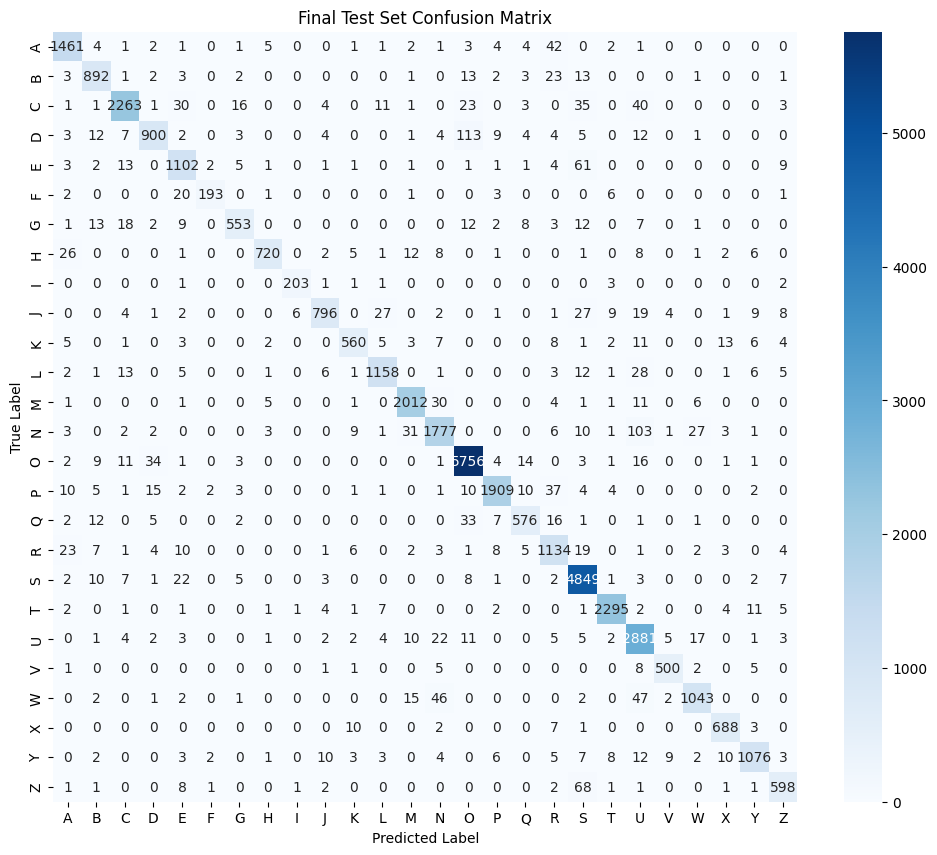

In [14]:
# ==========================================
# 8. FINAL EVALUATION 
# ==========================================
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Option A: Quick Score (Loss & Accuracy)
print("\nComputing final metrics...")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Option B: Detailed Analysis (Confusion Matrix, Reports)
print("\nGenerating predictions for detailed analysis...")
y_test_true = []
y_test_pred = []

# Iterate through the test dataset to get predictions vs ground truth
for images, labels in test_ds:
    # Get model predictions
    preds = model.predict(images, verbose=0)
    
    # Convert predictions to class indices (0-25)
    y_test_pred.extend(np.argmax(preds, axis=1))
    
    # Convert one-hot labels back to class indices
    y_test_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate Report
labels_list = [chr(65+i) for i in range(26)] # 'A' to 'Z'

print("\nFinal Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels_list))

# Generate Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list, yticklabels=labels_list)
plt.title('Final Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

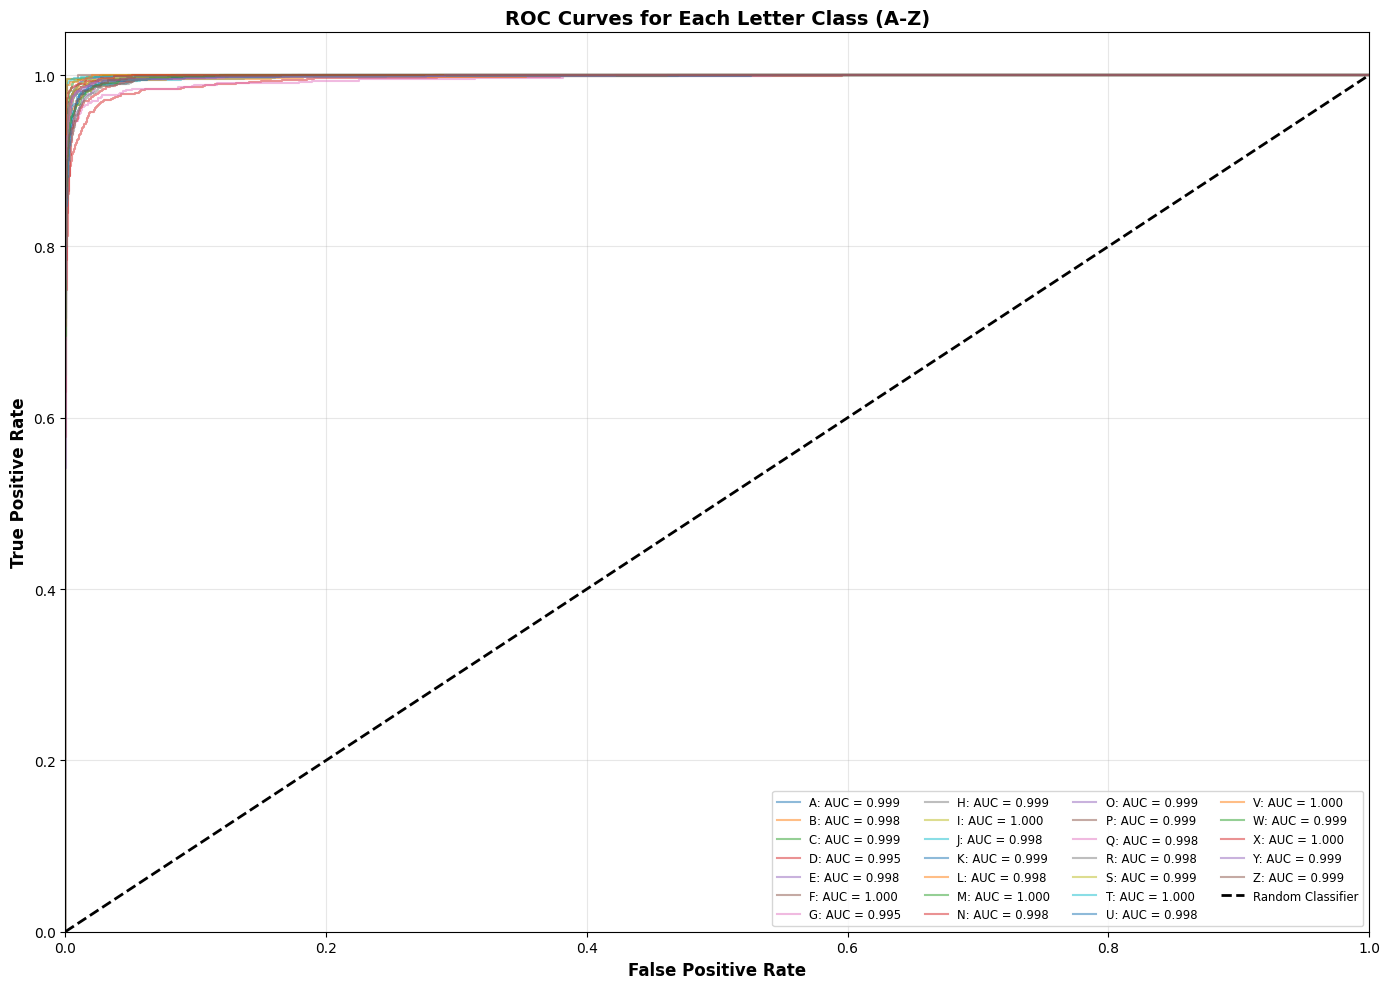


AUC SCORES FOR EACH CLASS
  A: 0.9995
  B: 0.9985
  C: 0.9988
  D: 0.9950
  E: 0.9984
  F: 0.9999
  G: 0.9954
  H: 0.9986
  I: 0.9998
  J: 0.9982
  K: 0.9989
  L: 0.9983
  M: 0.9997
  N: 0.9977
  O: 0.9990
  P: 0.9992
  Q: 0.9983
  R: 0.9978
  S: 0.9992
  T: 0.9998
  U: 0.9979
  V: 0.9998
  W: 0.9986
  X: 0.9996
  Y: 0.9986
  Z: 0.9986


In [15]:

# D. ROC & AUC Analysis
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC calculation
y_true_bin = label_binarize(y_true, classes=np.arange(26))
y_pred_bin = label_binarize(y_pred_classes, classes=np.arange(26))

# Calculate ROC curves for each class
plt.figure(figsize=(14, 10))
fpr_dict = dict()
tpr_dict = dict()
auc_dict = dict()

for i in range(26):
    try:
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
        plt.plot(fpr_dict[i], tpr_dict[i], lw=1.5, alpha=0.5,
                 label=f'{labels_list[i]}: AUC = {auc_dict[i]:.3f}')
    except:
        pass

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves for Each Letter Class (A-Z)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", ncol=4, fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC Summary
print("\n" + "="*70)
print("AUC SCORES FOR EACH CLASS")
print("="*70)
for i in range(26):
    if i in auc_dict:
        print(f"  {labels_list[i]}: {auc_dict[i]:.4f}")